In [40]:
from sklearn.manifold import Isomap
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra
import matplotlib.pyplot as plt
# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
from matplotlib import ticker
from skimage.metrics import structural_similarity as ssim

def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    #ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    #ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

def getCoresetConstructionError(data, coreset_indices, n_neighbors,display=1,s_color=None):
    """
    Compute the manifold loss for a given coreset.

    Parameters:
    - data: numpy array of shape (n_samples, n_features)
    - coreset: numpy array of shape (n_coreset, n_features)
    - n_neighbors: number of neighbors to use for constructing the neighborhood graph

    Returns:
    - loss: float
    """
    coreset = data[sampled_indices,:]
    n_samples = data.shape[0]
    n_coreset = coreset.shape[0]
    # Fit an Isomap on the complete dataset

    # Create an Isomap object
    isomap_complete = Isomap(n_neighbors=5, n_components=2)
    # Fit the model to your data
    isomap_complete.fit(data)
    # Access the geodesic distance matrix
    G1_d = isomap_complete.dist_matrix_
    # Geodesic distances b/w data points and the coreset
    G1 = G1_d[:,coreset_indices]

    #print(1)

    # Fit an Isomap on the coreset

    # Create an Isomap object
    isomap_coreset = Isomap(n_neighbors=5, n_components=2)
    # Fit the model to your data
    isomap_coreset.fit(coreset)
    # Access the geodesic distance matrix
    G2_d = isomap_coreset.dist_matrix_

    #print(2)

    # Compute geodesic distances for all points to the coreset

    # Euclidean distance between all the data points and the coreset
    distances_to_coreset = pairwise_distances(data, coreset, metric='euclidean')
    # Create a graph from the distance matrix by connecting each point to its nearest neighbors
    graph = np.full((n_samples, n_samples), np.inf)

    d2c = np.full((n_samples, n_samples), np.inf)
    d2c[:,coreset_indices] = distances_to_coreset

    n_neighbors_coreset = n_neighbors
    for i in range(n_samples):
        # Find the indices of the nearest coreset points
        nearest_indices = np.argsort(d2c[i])[:n_neighbors_coreset]

        # Fill the graph with the corresponding distances
        graph[i, nearest_indices] = d2c[i, nearest_indices]

    # Convert the graph into a sparse matrix
    sparse_graph = csr_matrix(graph)

    # Compute the shortest paths using Dijkstra's algorithm
    G2_d = dijkstra(sparse_graph, directed=False, return_predecessors=False)
    G2 = G2_d[:,coreset_indices]
    #print(3)

    if display == 1:
      y1 = isomap_complete.transform(data)
      y2 = y1.copy()
      for i in range(n_samples):
        y2[i,:] = isomap_coreset.transform([data[i,:]])




      plot_3d(data, s_color, "3D swiss roll")
      plot_2d(y1,s_color,"2D flattened swiss roll (full data)")
      plot_2d(y2,s_color,"2D flattened swiss roll (coreset)")

    mps_corr = np.corrcoef(G1.flatten(),G2.flatten())[0,1]
    mps_ssim = ssim(G1,G2, data_range=G1.max() - G1.min())

    return mps_ssim




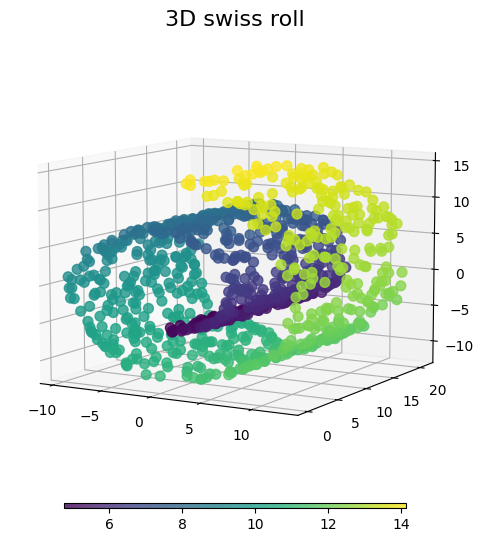

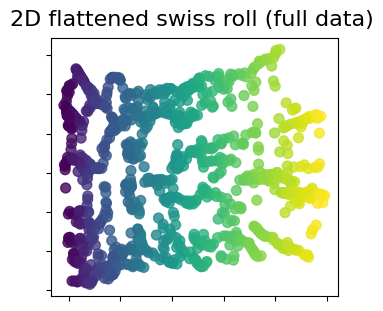

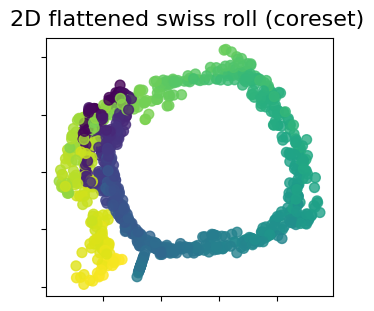

The manifold preservation score (SSIM) =  0.3181718308374847


In [41]:
from sklearn.datasets import make_swiss_roll
import random
n_neighbors = 5

data, s_color = make_swiss_roll(n_samples=1000, noise=0.1, random_state=42)

# Random sampling
sample_size = 200
sampled_indices = np.random.choice(data.shape[0], size=sample_size, replace=False)

# Get the manifold preservation score using SSIM
MPS = getCoresetConstructionError(np.array(data), sampled_indices, n_neighbors,display=1, s_color=s_color)
print('The manifold preservation score (SSIM) = ', MPS)







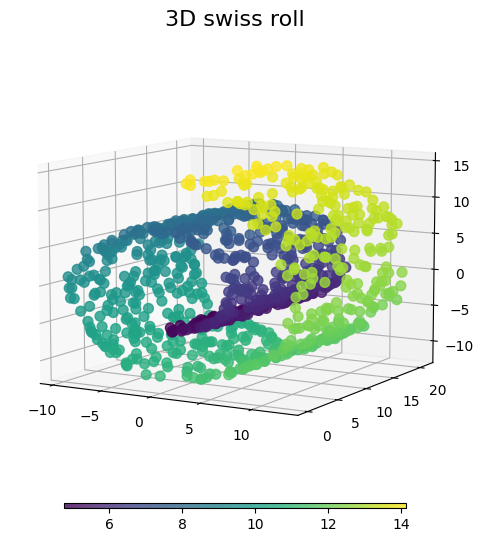

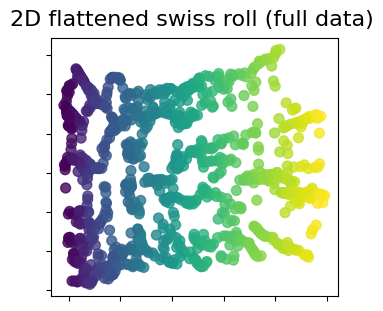

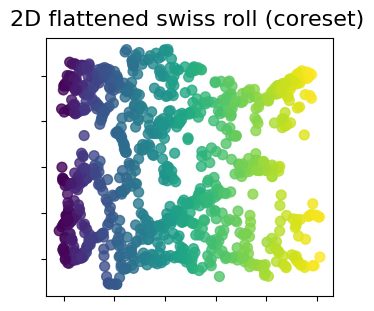

The manifold preservation score (SSIM) =  0.9976074462517895


In [42]:
from sklearn.datasets import make_swiss_roll
import random
n_neighbors = 5

data, s_color = make_swiss_roll(n_samples=1000, noise=0.1, random_state=42)

# Random sampling
sample_size = 700
sampled_indices = np.random.choice(data.shape[0], size=sample_size, replace=False)

# Get the manifold preservation score using SSIM
MPS = getCoresetConstructionError(np.array(data), sampled_indices, n_neighbors,display=1, s_color=s_color)
print('The manifold preservation score (SSIM) = ', MPS)


